# Module 8

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from functions import *

### Part 1. Linear Regression

Will train model with non-drought years then test for drought years

In [2]:
trj_smpp = xr.open_dataset('./trj_sm_pp.nc')
vidmf = xr.open_dataset('./vidmf_mwc.nc')

In [3]:
def is_warm(month):
    # Select months from April to September
    return (month >= 4) & (month <= 9)

def is_not_drought(year):
    # Select years except 1988 and 2012 
    return (year != 1988) & (year != 2012)    

def is_drought(year):
    # Select years with extreme drought, 1988 and 2012
    return (year == 1988) | (year == 2012)    

In [4]:
# Preparing training dataset
trj_smpp_nod = trj_smpp.sel(time = is_not_drought(trj_smpp.time.dt.year))
vimdf_nod = vidmf.sel(time = is_not_drought(vidmf.time.dt.year))

XTrain = np.hstack((trj_smpp_nod.sm_ano.values, trj_smpp_nod.et_ano.values))
YTrain = vimdf_nod['p84.162'].sel(time=is_warm(vimdf_nod.time.dt.month)).sel(time=slice('1980-01-01','2019-12-31')).values

In [5]:
# Preparing "test" dataset, which is 1988 and 2012 drought years
trj_smpp_d = trj_smpp.sel(time = is_drought(trj_smpp.time.dt.year))
vimdf_d = vidmf.sel(time=is_warm(vidmf.time.dt.month))
vimdf_d = vimdf_d.sel(time = is_drought(vimdf_d.time.dt.year))

Xtest = np.hstack((trj_smpp_d.sm_ano.values, trj_smpp_d.et_ano.values))
Ytest = vimdf_d['p84.162'].values

In [6]:
# Remove if training or test dataset has NaN values
nanmask = [~np.isnan(XTrain.sum(axis=1))]
XTrain = XTrain[nanmask]
YTrain = YTrain[nanmask]

nanmask2 = [~np.isnan(Xtest.sum(axis=1))]
Xtest = Xtest[nanmask2]
Ytest = Ytest[nanmask2]

<ipython-input-6-39a632cc1a45>:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  XTrain = XTrain[nanmask]
<ipython-input-6-39a632cc1a45>:4: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  YTrain = YTrain[nanmask]
<ipython-input-6-39a632cc1a45>:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Xtest = Xtest[nanmask2]
<i

In [7]:
from sklearn.linear_model import LinearRegression
model_lr = LinearRegression(fit_intercept=False)
model_lr.fit(XTrain, YTrain)
Ypred = model_lr.predict(Xtest)

(-0.0002, 0.0002)

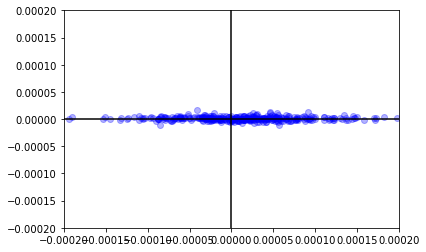

In [8]:
plt.scatter(Ytest, Ypred, color='b', alpha=0.3)
lmv = 0.0002
plt.axhline(color='k')
plt.axvline(color='k')
plt.xlim([-lmv, lmv])
plt.ylim([-lmv, lmv])

In [9]:
from sklearn import metrics

print('Linear Regression')
print('R2 = ', metrics.r2_score(Ytest, Ypred))
print('RMSE = ', np.sqrt(metrics.mean_squared_error(Ytest, Ypred)), '\n')

Linear Regression
R2 =  -0.028014380862623423
RMSE =  6.966462191957777e-05 



Obviously, linear regression is not doing a good job. Maybe too many predictors are considered here, which is leading to awkward behaviour of the model. Then, let's reduce the number of predictors. Like SM and PP anomalies of the last 3 days, instead of 10 days. 

In [10]:
model_lr3 = LinearRegression(fit_intercept=False)
model_lr3.fit(XTrain[:,[1,2,3,11,12,13]], YTrain)
Ypred3 = model_lr3.predict(Xtest[:,[1,2,3,11,12,13]])

Linear Regression
R2 =  -0.02781614876199412
RMSE =  6.965790487826081e-05 



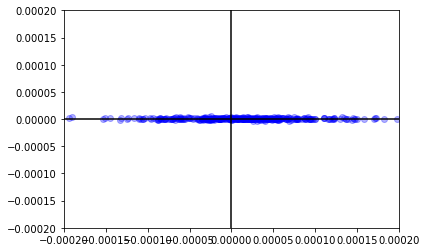

In [11]:
plt.scatter(Ytest, Ypred3, color='b', alpha=0.3)
lmv = 0.0002
plt.axhline(color='k')
plt.axvline(color='k')
plt.xlim([-lmv, lmv])
plt.ylim([-lmv, lmv])

print('Linear Regression')
print('R2 = ', metrics.r2_score(Ytest, Ypred3))
print('RMSE = ', np.sqrt(metrics.mean_squared_error(Ytest, Ypred3)), '\n')

There's no a significant difference between two results. I tried to train model with different setting, but had no fortune to get a descent model. At this stage, I wanted check again how each variable fluctuates.

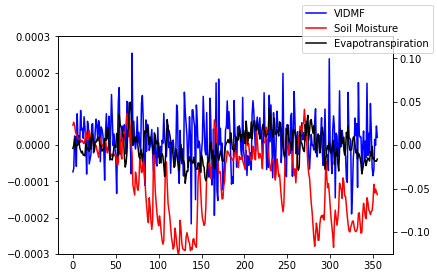

In [12]:
fig, ax = plt.subplots()
ax.plot(Ytest, 'b', label='VIDMF')
ax.set_ylim([-0.0003, 0.0003])
ax2 = ax.twinx()
ax2.plot(Xtest[:,0], 'r', label='Soil Moisture')
ax2.plot(-Xtest[:,10]*1000, 'k', label='Evapotranspiration')
ax2.set_ylim([-0.125, 0.125])
fig.legend()

They look quite noisy, which means that it might need to be smooth these variables for better results.

### Part 2. Linear Regression with pre-processing

In [13]:
# Rolling means
trj_smpp_roll = trj_smpp.rolling(time=5, center=True).mean()  # 5-day mean
vidmf_roll = vidmf.rolling(time=15, center=True).mean()  # 15-day mean

In [14]:
# Now let's replace previous dataset with smoothed ones
trj_smpp_nod = trj_smpp_roll.sel(time = is_not_drought(trj_smpp_roll.time.dt.year))
vimdf_nod = vidmf_roll.sel(time = is_not_drought(vidmf_roll.time.dt.year))

XTrain = np.hstack((trj_smpp_nod.sm_ano.values, trj_smpp_nod.et_ano.values))
YTrain = vimdf_nod['p84.162'].sel(time=is_warm(vimdf_nod.time.dt.month)).sel(time=slice('1980-01-01','2019-12-31')).values

trj_smpp_d = trj_smpp_roll.sel(time = is_drought(trj_smpp_roll.time.dt.year))
vimdf_d = vidmf_roll.sel(time=is_warm(vidmf_roll.time.dt.month))
vimdf_d = vimdf_d.sel(time = is_drought(vimdf_d.time.dt.year))

Xtest = np.hstack((trj_smpp_d.sm_ano.values, trj_smpp_d.et_ano.values))
Ytest = vimdf_d['p84.162'].values

# Remove if training or test dataset has NaN values
nanmask = [~np.isnan(XTrain.sum(axis=1))]
XTrain = XTrain[nanmask]
YTrain = YTrain[nanmask]

nanmask2 = [~np.isnan(Xtest.sum(axis=1))]
Xtest = Xtest[nanmask2]
Ytest = Ytest[nanmask2]

<ipython-input-14-dbec4bee68dc>:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  XTrain = XTrain[nanmask]
<ipython-input-14-dbec4bee68dc>:18: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  YTrain = YTrain[nanmask]
<ipython-input-14-dbec4bee68dc>:21: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Xtest = Xtest[nanmas

In [19]:
model_lr = LinearRegression(fit_intercept=False)
model_lr.fit(XTrain, YTrain)
Ypred = model_lr.predict(Xtest)

Linear Regression
R2 =  -0.5423330615193909
RMSE =  1.8973463419892852e-05 



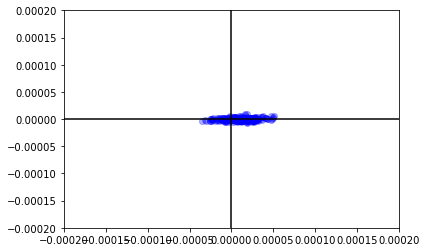

In [20]:
plt.scatter(Ytest, Ypred, color='b', alpha=0.3)
lmv = 0.0002
plt.axhline(color='k')
plt.axvline(color='k')
plt.xlim([-lmv, lmv])
plt.ylim([-lmv, lmv])

print('Linear Regression')
print('R2 = ', metrics.r2_score(Ytest, Ypred))
print('RMSE = ', np.sqrt(metrics.mean_squared_error(Ytest, Ypred)), '\n')

Still, the model basically has no skill and it became worse. Can this be solved by using values around "drought" cases? 

### Part 3. Linear Regression with 25th percentile values

It might be because we are using all the values during the given period. As we are predicting values during extreme drought cases, let's try using lowest 25th percentile values of the soil moisture.

In [21]:
# Get 25th percentile value of the Midwest soil moisture
sm25th = np.nanpercentile(trj_smpp_roll.sm_ano[:,0].values, 25)

In [22]:
trj_smpp_25th = trj_smpp_roll.where((trj_smpp_roll.sm_ano[:,0] < sm25th), drop=True)
time25 = trj_smpp_25th.time
vidmf_25th = vidmf_roll.where(vidmf_roll.time == time25, drop=True)

In [23]:
# Now let's replace previous dataset with smoothed ones
trj_smpp_nod_25 = trj_smpp_25th.sel(time = is_not_drought(trj_smpp_25th.time.dt.year))
vimdf_nod_25 = vidmf_25th.sel(time = is_not_drought(vidmf_25th.time.dt.year))

XTrain_25 = np.hstack((trj_smpp_nod_25.sm_ano.values, trj_smpp_nod_25.et_ano.values))
YTrain_25 = vimdf_nod_25['p84.162'].sel(time=is_warm(vimdf_nod_25.time.dt.month)).sel(time=slice('1980-01-01','2019-12-31')).values

trj_smpp_d_25 = trj_smpp_25th.sel(time = is_drought(trj_smpp_25th.time.dt.year))
vimdf_d_25 = vidmf_25th.sel(time = is_warm(vidmf_25th.time.dt.month))
vimdf_d_25 = vimdf_d_25.sel(time = is_drought(vimdf_d_25.time.dt.year))

Xtest_25 = np.hstack((trj_smpp_d_25.sm_ano.values, trj_smpp_d_25.et_ano.values))
Ytest_25 = vimdf_d_25['p84.162'].values

# Remove if training or test dataset has NaN values
nanmask = [~np.isnan(XTrain_25.sum(axis=1))]
XTrain_25 = XTrain_25[nanmask]
YTrain_25 = YTrain_25[nanmask]

nanmask2 = [~np.isnan(Xtest_25.sum(axis=1))]
Xtest_25 = Xtest_25[nanmask2]
Ytest_25 = Ytest_25[nanmask2]

<ipython-input-23-cceba4531ed4>:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  XTrain_25 = XTrain_25[nanmask]
<ipython-input-23-cceba4531ed4>:18: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  YTrain_25 = YTrain_25[nanmask]
<ipython-input-23-cceba4531ed4>:21: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Xtest_25

In [24]:
model_25 = LinearRegression(fit_intercept=False)
model_25.fit(XTrain_25[:,np.arange(10,15)], YTrain_25)
Ypred_25 = model_25.predict(Xtest_25[:,np.arange(10,15)])

Linear Regression
R2 =  -0.39710675249211946
RMSE =  1.5408572195234362e-05 



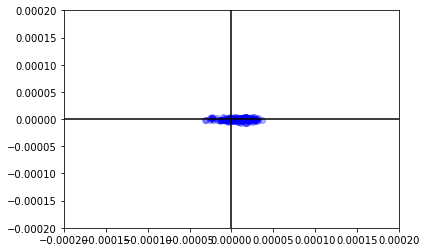

In [25]:
plt.scatter(Ytest_25, Ypred_25, color='b', alpha=0.3)
lmv = 0.0002
plt.axhline(color='k')
plt.axvline(color='k')
plt.xlim([-lmv, lmv])
plt.ylim([-lmv, lmv])

print('Linear Regression')
print('R2 = ', metrics.r2_score(Ytest_25, Ypred_25))
print('RMSE = ', np.sqrt(metrics.mean_squared_error(Ytest_25, Ypred_25)), '\n')

The R2 score looks slightly better. Still, the model is basically doing nothing...

### Part 4. Neural Network from sklearn

Before using neural network, I tried random forests with randomized search, but the result was a bit disappointing like a simple linear regression.
Will more complex models like neural network give better results? Let's try multi-layer percentron model here.

In [26]:
from sklearn.neural_network import MLPRegressor

In [86]:
# layer = (256,256,256,256,256)
layer = (512,256,128,64,32)  
# layer = (512,256,128,64,32,16,8)
# layer = (4,4,4,4)  
regr = MLPRegressor(hidden_layer_sizes=layer, activation="relu", random_state=5, max_iter=1000).fit(XTrain[:,[1,2,3,11,12,13]], YTrain)
Ypred_mlp = regr.predict(Xtest[:,[1,2,3,11,12,13]])

Neural Network
R2 =  -19.23047071317061
RMSE =  6.87164197894859e-05 



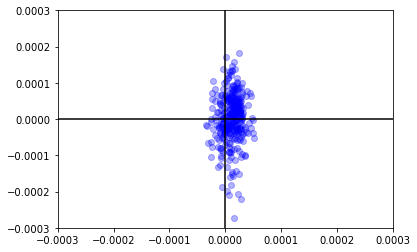

In [87]:
plt.scatter(Ytest, Ypred_mlp, color='b', alpha=0.3)
lmv = 0.0003
plt.axhline(color='k')
plt.axvline(color='k')
plt.xlim([-lmv, lmv])
plt.ylim([-lmv, lmv])

print('Neural Network')
print('R2 = ', metrics.r2_score(Ytest, Ypred_mlp))
print('RMSE = ', np.sqrt(metrics.mean_squared_error(Ytest, Ypred_mlp)), '\n')

I've tried many hyperparameters and tried to use different input data. But, unfortunately, I couldn't find any better model that can beat the simplest linear regression model for this case. 

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

param_grid_rf = {'bootstrap': [True, False],  
                 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],  
                 'max_features': ['auto', 'sqrt'],  
                 'min_samples_leaf': [1, 2, 4],  
                 'min_samples_split': [2, 5, 10],  }

grid_rf = RandomizedSearchCV(RandomForestRegressor(), param_grid_rf, n_iter=100, scoring="r2", n_jobs=-1)

In [ ]:
import pickle

# save the model to disk
filename = 'rf_model.sav'
# pickle.dump(model_rf, open(filename, 'wb'))
 
# # load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
Ypred_rf = loaded_model.predict(Xtest)

Neural Network
R2 =  -0.7107188423089017
RMSE =  1.9982363253938874e-05 



/opt/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.24.1 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.24.1 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


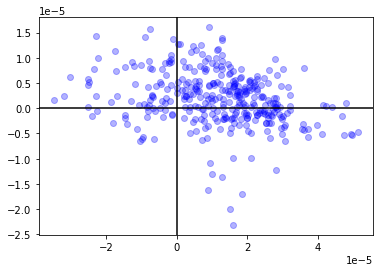

In [90]:
plt.scatter(Ytest, Ypred_rf, color='b', alpha=0.3)
lmv = 0.0003
plt.axhline(color='k')
plt.axvline(color='k')
# plt.xlim([-lmv, lmv])
# plt.ylim([-lmv, lmv])

print('Neural Network')
print('R2 = ', metrics.r2_score(Ytest, Ypred_rf))
print('RMSE = ', np.sqrt(metrics.mean_squared_error(Ytest, Ypred_rf)), '\n')